In [13]:
import pandas as pd
df=pd.read_csv(r'D:\Manasa College\SE\venv\data\diabetes.csv')
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- 1. Load Data ---
df = pd.read_csv(r'D:\Manasa College\SE\venv\data\diabetes.csv')

# --- 2. Handle Implausible Zeros (Missing Data Imputation) ---
# Define columns where 0 represents a missing value
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0s with NaN
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)

# Initialize SimpleImputer to replace NaN with the median of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Impute the missing values in the defined columns
df[cols_to_replace] = imputer.fit_transform(df[cols_to_replace])


# --- 3. Data Splitting: Features (X) and Target (y) ---
# 'Outcome' is the target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data into training (80%) and testing (20%) sets
# stratify=y ensures both sets have the same proportion of Outcome (0s and 1s)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# --- 4. Feature Scaling ---
# Scaling is crucial for models based on distance, like Logistic Regression (our next step)
scaler = StandardScaler()

# Fit the scaler ONLY on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the parameters learned from the training data
X_test_scaled = scaler.transform(X_test)


# Fit model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))


print("Preprocessing Complete.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Accuracy: 0.7532467532467533
Preprocessing Complete.
X_train_scaled shape: (614, 8)
X_test_scaled shape: (154, 8)


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier # 🎯 Import the XGBoost classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


# --- RE-RUNNING PREPROCESSING TO ENSURE DATA IS READY ---

# Load Data
df = pd.read_csv(r'D:\Manasa College\SE\venv\data\diabetes.csv')

# Handle Implausible Zeros (Missing Data Imputation)
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[cols_to_replace] = imputer.fit_transform(df[cols_to_replace])

# Data Splitting
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- XGBOOST MODEL TRAINING AND EVALUATION ---

# 1. Initialize the XGBoost Classifier
# We use a modest learning_rate and number of estimators as a starting point.
# Using the default 100 estimators is usually a good start.
xgb_model = XGBClassifier(
    objective='binary:logistic', # Required for binary classification
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)



# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Create base model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Create the grid search object
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,              # 3-fold cross validation
    verbose=1,
    n_jobs=-1          # use all CPU cores
)

# Fit on training data
print("Starting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train_scaled, y_train)

# Show best parameters and score
print("\nBest Parameters Found:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


# 2. Train the Model
print("Starting XGBoost training...")
xgb_model.fit(X_train_scaled, y_train)

# 3. Make Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4. Evaluate Performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n-------------------------------------------")
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("-------------------------------------------")
print("\nXGBoost Classification Report:\n", report_xgb)
print("\nXGBoost Confusion Matrix:\n", cm_xgb)


# 5. Plot Confusion Matrix (Optional but Recommended)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
            yticklabels=['No Diabetes (0)', 'Diabetes (1)'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('xgboost_confusion_matrix.png')
plt.close()

Starting Grid Search for Hyperparameter Tuning...
Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


🔍 Starting random Search for Hyperparameter Tuning...
Fitting 2 folds for each of 10 candidates, totalling 20 fits

✅ Grid Search Completed!
Best Parameters Found: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation Accuracy: 0.7704

-------------------------------------------
Tuned XGBoost Test Accuracy: 0.7468
-------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154


Confusion Matrix:
 [[86 14]
 [25 29]]


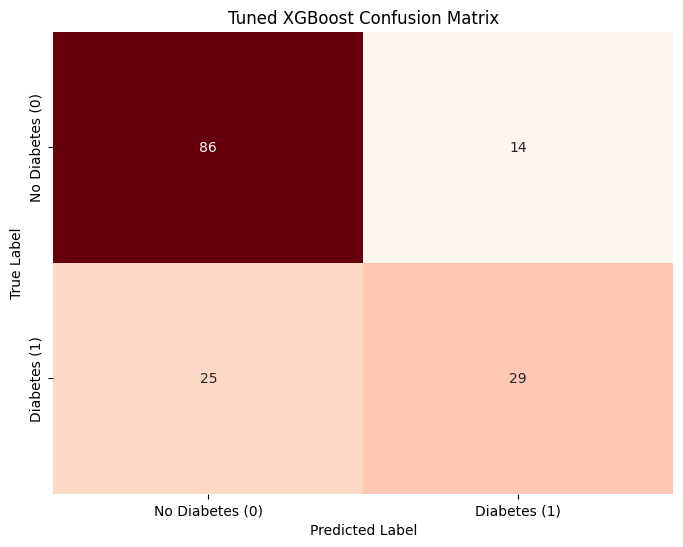

<Figure size 1000x600 with 0 Axes>

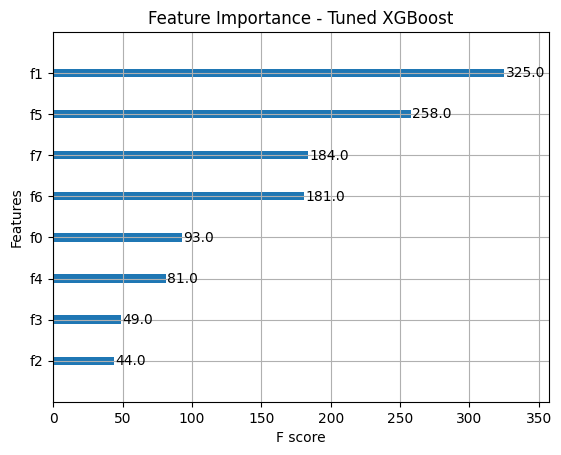

In [13]:
# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: LOAD DATA ---
df = pd.read_csv(r'D:\Manasa College\SE\venv\data\diabetes.csv')

# --- STEP 2: HANDLE IMPOSSIBLE ZEROS (TREAT AS MISSING VALUES) ---
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[cols_to_replace] = imputer.fit_transform(df[cols_to_replace])

# --- STEP 3: SPLIT INTO FEATURES AND TARGET ---
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- STEP 4: FEATURE SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 5: BASE MODEL SETUP ---
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=1
)

# --- STEP 6: DEFINE HYPERPARAMETER GRID ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

# --- STEP 7: RND SEARCH INITIALIZATION ---
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,     # only try 20 random combinations
    scoring='accuracy',
    cv=2,
    verbose=1,
    n_jobs=1,
    random_state=42
)
# --- STEP 8: RUN GRID SEARCH ---
print("🔍 Starting random Search for Hyperparameter Tuning...")
random_search.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Completed!")
print("Best Parameters Found:", random_search.best_params_)
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.4f}")

# --- STEP 9: TRAIN BEST MODEL ON TRAINING DATA ---
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train_scaled, y_train)

# --- STEP 10: MAKE PREDICTIONS ---
y_pred_best = best_xgb.predict(X_test_scaled)

# --- STEP 11: EVALUATE PERFORMANCE ---
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
cm_best = confusion_matrix(y_test, y_pred_best)

print("\n-------------------------------------------")
print(f"Tuned XGBoost Test Accuracy: {accuracy_best:.4f}")
print("-------------------------------------------")
print("\nClassification Report:\n", report_best)
print("\nConfusion Matrix:\n", cm_best)

# --- STEP 12: PLOT CONFUSION MATRIX ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
            yticklabels=['No Diabetes (0)', 'Diabetes (1)'])
plt.title('Tuned XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- STEP 13: FEATURE IMPORTANCE (OPTIONAL) ---
plt.figure(figsize=(10, 6))
plot_importance(best_xgb)
plt.title('Feature Importance - Tuned XGBoost')
plt.show()


In [30]:
# ============================================
# FEATURE-SPECIALIZED HYBRID MODEL FOR DIABETES
# SVM + XGBoost + Neural Network
# Each model trained on its best features
# Final output = average of predictions
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# ---------------------------
# STEP 1: LOAD DATA
# ---------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes.csv")

# Columns expected:
# ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age','Outcome']

# ---------------------------
# STEP 2: DEFINE FEATURE GROUPS FOR EACH MODEL
# ---------------------------
svm_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']
xgb_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'Pregnancies', 'DiabetesPedigreeFunction', 'BloodPressure']
nn_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction']

# ---------------------------
# STEP 3: TRAIN-TEST SPLIT
# ---------------------------
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def test_subset(model, feature_list, name):
    X_train_sub = X_train[feature_list]
    X_test_sub = X_test[feature_list]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sub)
    X_test_scaled = scaler.transform(X_test_sub)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy ({len(feature_list)} features): {acc:.3f}")

test_subset(SVC(kernel='rbf', probability=True, random_state=42), svm_features, "SVM")
test_subset(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_features, "XGBoost")
test_subset(MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42), nn_features, "Neural Network")

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# ---------------------------
# STEP 4: SCALE EACH FEATURE GROUP
# ---------------------------
scaler_svm = StandardScaler()
scaler_xgb = StandardScaler()
scaler_nn = StandardScaler()

X_train_svm = scaler_svm.fit_transform(X_train_bal)
X_test_svm = scaler_svm.transform(X_test)

X_train_xgb = scaler_xgb.fit_transform(X_train_bal)
X_test_xgb = scaler_xgb.transform(X_test)

X_train_nn = scaler_nn.fit_transform(X_train_bal)
X_test_nn = scaler_nn.transform(X_test)

# ---------------------------
# STEP 5: DEFINE MODELS
# ---------------------------
svm_model = SVC(probability=True, kernel='rbf', C=1, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          n_estimators=100, learning_rate=0.1, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu',
                         solver='adam', max_iter=300, random_state=42)

# ---------------------------
# STEP 6: TRAIN MODELS ON THEIR FEATURES
# ---------------------------
print("🚀 Training specialized models...")

svm_model.fit(X_train_svm, y_train_bal)
xgb_model.fit(X_train_xgb, y_train_bal)
nn_model.fit(X_train_nn, y_train_bal)

# ---------------------------
# STEP 7: INDIVIDUAL MODEL PREDICTIONS
# ---------------------------
svm_probs = svm_model.predict_proba(X_test_svm)[:,1]
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:,1]
nn_probs = nn_model.predict_proba(X_test_nn)[:,1]

# ---------------------------
# STEP 8: COMBINE PREDICTIONS (AVERAGE VOTING)
# ---------------------------
final_probs = (svm_probs + xgb_probs + nn_probs) / 3
final_pred = (final_probs >= 0.5).astype(int)

# ---------------------------
# STEP 9: EVALUATE PERFORMANCE
# ---------------------------
accuracy = accuracy_score(y_test, final_pred)
print(f"\n✅ Final Hybrid Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, final_pred))

# ---------------------------
# STEP 10: SAVE MODELS & SCALERS
# ---------------------------
joblib.dump(svm_model, 'svm_specialized.pkl')
joblib.dump(xgb_model, 'xgb_specialized.pkl')
joblib.dump(nn_model, 'nn_specialized.pkl')
joblib.dump(scaler_svm, 'scaler_svm.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl')
joblib.dump(scaler_nn, 'scaler_nn.pkl')
print("\n💾 Models and scalers saved successfully!")

# ---------------------------
# STEP 12: USER INPUT SECTION
# ---------------------------
'''
print("\n💡 Enter your medical details below to predict diabetes:\n")
user_input = {
    'Pregnancies': float(input("Enter number of pregnancies: ")),
    'Glucose': float(input("Enter glucose level: ")),
    'BloodPressure': float(input("Enter blood pressure: ")),
    'SkinThickness': float(input("Enter skin thickness: ")),
    'Insulin': float(input("Enter insulin level: ")),
    'BMI': float(input("Enter BMI: ")),
    'DiabetesPedigreeFunction': float(input("Enter diabetes pedigree function value: ")),
    'Age': float(input("Enter age: "))
}

user_df = pd.DataFrame([user_input])

# ---------------------------
# STEP 13: MAKE FINAL PREDICTION
# ---------------------------

# Scale each group
s_svm = scaler_svm.transform(user_df)
s_xgb = scaler_xgb.transform(user_df)
s_nn = scaler_nn.transform(user_df)

# Predict from each model
p_svm = svm_model.predict_proba(s_svm)[:,1]
p_xgb = xgb_model.predict_proba(s_xgb)[:,1]
p_nn = nn_model.predict_proba(s_nn)[:,1]
'''
# Average
final_probs = (0.2 * svm_probs + 0.5 * xgb_probs + 0.3 * nn_probs)
final_pred = int(final_probs[0] >= 0.5)

print("\n🔍 Final Prediction:", "Diabetic" if final_pred == 1 else "Non-Diabetic")
print(f"🧮 Final Probability: {final_probs[0]:.4f}")

SVM Accuracy (5 features): 0.747
XGBoost Accuracy (7 features): 0.747
Neural Network Accuracy (5 features): 0.747
🚀 Training specialized models...

✅ Final Hybrid Accuracy: 74.68%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       100
           1       0.61      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.75      0.75       154


💾 Models and scalers saved successfully!

🔍 Final Prediction: Diabetic
🧮 Final Probability: 0.9244


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [28]:
# ============================================
# FEATURE-SPECIALIZED HYBRID MODEL FOR DIABETES
# SVM + XGBoost + Neural Network
# Each model trained on its best features
# Final output = average of predictions
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# ---------------------------
# STEP 1: LOAD DATA
# ---------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes.csv")

# Columns expected:
# ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age','Outcome']

# ---------------------------
# STEP 2: DEFINE FEATURE GROUPS FOR EACH MODEL
# ---------------------------
#svm_features = ['Pregnancies', 'BloodPressure', 'SkinThickness']
#xgb_features = ['Glucose', 'Insulin']
#nn_features = ['BMI', 'Age']

# ---------------------------
# STEP 3: TRAIN-TEST SPLIT
# ---------------------------
X = df.drop('Outcome', axis=1)
y = df['Outcome']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# ---------------------------
# STEP 4: SCALE EACH FEATURE GROUP
# ---------------------------
scaler_svm = StandardScaler()
scaler_xgb = StandardScaler()
scaler_nn = StandardScaler()

X_train_svm = scaler_svm.fit_transform(X_train_bal)
X_test_svm = scaler_svm.transform(X_test)

X_train_xgb = scaler_xgb.fit_transform(X_train_bal)
X_test_xgb = scaler_xgb.transform(X_test)

X_train_nn = scaler_nn.fit_transform(X_train_bal)
X_test_nn = scaler_nn.transform(X_test)

# ---------------------------
# STEP 5: DEFINE MODELS
# ---------------------------
svm_model = SVC(probability=True, kernel='rbf', C=10, gamma='scale',random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          n_estimators=200, learning_rate=0.05, max_depth=4,random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu',
                         solver='adam',alpha=0.001, max_iter=500, random_state=42)

# ---------------------------
# STEP 6: TRAIN MODELS ON THEIR FEATURES
# ---------------------------
print("🚀 Training specialized models...")

svm_model.fit(X_train_svm, y_train_bal)
xgb_model.fit(X_train_xgb, y_train_bal)
nn_model.fit(X_train_nn, y_train_bal)

# ---------------------------
# STEP 7: INDIVIDUAL MODEL PREDICTIONS
# ---------------------------
svm_probs = svm_model.predict_proba(X_test_svm)[:,1]
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:,1]
nn_probs = nn_model.predict_proba(X_test_nn)[:,1]

# ---------------------------
# STEP 8: COMBINE PREDICTIONS (AVERAGE VOTING)
# ---------------------------
final_probs = (0.3 * svm_probs + 0.4 * xgb_probs + 0.3 * nn_probs)
final_pred = (final_probs >= 0.5).astype(int)

# ---------------------------
# STEP 9: EVALUATE PERFORMANCE
# ---------------------------
accuracy = accuracy_score(y_test, final_pred)
print(f"\n✅ Final Hybrid Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, final_pred))

# ---------------------------
# STEP 10: SAVE MODELS & SCALERS
# ---------------------------
joblib.dump(svm_model, 'svm_specialized.pkl')
joblib.dump(xgb_model, 'xgb_specialized.pkl')
joblib.dump(nn_model, 'nn_specialized.pkl')
joblib.dump(scaler_svm, 'scaler_svm.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl')
joblib.dump(scaler_nn, 'scaler_nn.pkl')
print("\n💾 Models and scalers saved successfully!")

# ---------------------------
# STEP 12: USER INPUT SECTION
# ---------------------------
'''
print("\n💡 Enter your medical details below to predict diabetes:\n")

user_input = {
    'Pregnancies': float(input("Enter number of pregnancies: ")),
    'Glucose': float(input("Enter glucose level: ")),
    'BloodPressure': float(input("Enter blood pressure: ")),
    'SkinThickness': float(input("Enter skin thickness: ")),
    'Insulin': float(input("Enter insulin level: ")),
    'BMI': float(input("Enter BMI: ")),
    'DiabetesPedigreeFunction': float(input("Enter diabetes pedigree function value: ")),
    'Age': float(input("Enter age: "))
}

user_df = pd.DataFrame([user_input])

# ---------------------------
# STEP 13: MAKE FINAL PREDICTION
# ---------------------------

# Scale each group
s_svm = scaler_svm.transform(user_df)
s_xgb = scaler_xgb.transform(user_df)
s_nn = scaler_nn.transform(user_df)

# Predict from each model
p_svm = svm_model.predict_proba(s_svm)[:,1]
p_xgb = xgb_model.predict_proba(s_xgb)[:,1]
p_nn = nn_model.predict_proba(s_nn)[:,1]
'''
# Average
final_probs = (0.3 * svm_probs + 0.4 * xgb_probs + 0.3 * nn_probs)
final_pred = int(final_probs[0] >= 0.5)

print("\n🔍 Final Prediction:", "Diabetic" if final_pred == 1 else "Non-Diabetic")
print(f"🧮 Final Probability: {final_probs[0]:.4f}")


--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---
🚀 Training specialized models...

✅ Final Hybrid Accuracy: 68.63%

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75       100
           1       0.54      0.64      0.59        53

    accuracy                           0.69       153
   macro avg       0.66      0.68      0.67       153
weighted avg       0.70      0.69      0.69       153


💾 Models and scalers saved successfully!

🔍 Final Prediction: Diabetic
🧮 Final Probability: 0.8525


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


🚀 Training individual models...
✅ All models trained successfully!

🎯 Final Ensemble Accuracy: 77.92%

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       100
           1       0.74      0.57      0.65        54

    accuracy                           0.78       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.77      0.78      0.77       154

🔍 Confusion Matrix:
 [[89 11]
 [23 31]]


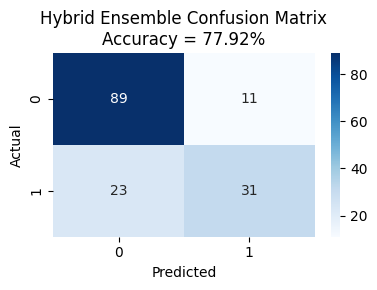

In [32]:
# ============================================================
# 🤖 HYBRID ENSEMBLE MODEL (SVM + XGBoost + Neural Network)
# Each uses its best feature subset
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# STEP 1: LOAD DATA
# ----------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes.csv")  # 8 features + 'Outcome'

features_all = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = df[features_all]
y = df['Outcome']

# ----------------------------
# STEP 2: SPLIT DATA
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ----------------------------
# STEP 3: DEFINE BEST FEATURES FOR EACH MODEL
# ----------------------------
features_svm = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']
features_xgb = ['Glucose', 'BMI', 'Age', 'Insulin', 'Pregnancies',
                'DiabetesPedigreeFunction', 'BloodPressure']
features_nn = ['Glucose', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction']

# ----------------------------
# STEP 4: SCALING (needed for SVM & NN)
# ----------------------------
scaler_svm = StandardScaler()
scaler_nn = StandardScaler()

X_train_svm = scaler_svm.fit_transform(X_train[features_svm])
X_test_svm = scaler_svm.transform(X_test[features_svm])

X_train_nn = scaler_nn.fit_transform(X_train[features_nn])
X_test_nn = scaler_nn.transform(X_test[features_nn])

# XGBoost doesn’t need scaling
X_train_xgb = X_train[features_xgb]
X_test_xgb = X_test[features_xgb]

# ----------------------------
# STEP 5: TRAIN INDIVIDUAL MODELS
# ----------------------------
print("🚀 Training individual models...")

svm_model = SVC(kernel='rbf', probability=True, C=1, random_state=42)
svm_model.fit(X_train_svm, y_train)

xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                         max_iter=1000, random_state=42)
nn_model.fit(X_train_nn, y_train)

print("✅ All models trained successfully!\n")

# ----------------------------
# STEP 6: PREDICT PROBABILITIES
# ----------------------------
svm_probs = svm_model.predict_proba(X_test_svm)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
nn_probs = nn_model.predict_proba(X_test_nn)[:, 1]

# ----------------------------
# STEP 7: ENSEMBLE WEIGHTED AVERAGE
# ----------------------------
# You can adjust weights (if you know model accuracy differences)
final_probs = (0.3 * svm_probs) + (0.4 * xgb_probs) + (0.3 * nn_probs)
final_pred = (final_probs >= 0.5).astype(int)

# ----------------------------
# STEP 8: EVALUATE PERFORMANCE
# ----------------------------
accuracy = accuracy_score(y_test, final_pred)
print(f"🎯 Final Ensemble Accuracy: {accuracy*100:.2f}%\n")

print("📄 Classification Report:\n", classification_report(y_test, final_pred))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, final_pred))

# ----------------------------
# STEP 9: VISUALIZE CONFUSION MATRIX
# ----------------------------
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"Hybrid Ensemble Confusion Matrix\nAccuracy = {accuracy*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes_prediction_dataset.csv")
print(df.head())
print(df.columns)

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')
